## LSTM Weather Forecast App 

## Imports

In [ ]:
import random, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

random.seed(46)
np.random.seed(46)
tf.random.set_seed(46)


## Customized Functions

In [ ]:
def load_and_preprocess(data_path):    
    data = pd.read_csv(data_path)
    
    data['temp_celsius'] = data['temp'] - 273.15
    # data['date'] = pd.to_datetime(data['dt_iso']).dt.date
    data['date'] = pd.to_datetime(data['dt_iso'], format='%Y-%m-%d %H:%M:%S +0000 UTC').dt.date
    data = data.drop(columns=['dt_iso', 'temp'])
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    
    return data.resample('D').mean()

def split_data_by_time(df, train_frac=0.7, val_frac=0.15):
    n = len(df)
    
    train_size = int(n * train_frac)
    val_size = int(n * val_frac)    
    test_size = n - train_size - val_size
    
    train_df = df[:train_size]
    val_df = df[train_size:train_size+val_size]
    test_df = df[train_size+val_size:]
    
    return train_df, val_df, test_df


def scale_data(train_df, val_df, test_df, feature_columns, target_column):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    scaler_x.fit(train_df[feature_columns])
    scaler_y.fit(train_df[[target_column]])
    
    train_x = scaler_x.transform(train_df[feature_columns])
    val_x = scaler_x.transform(val_df[feature_columns])
    test_x = scaler_x.transform(test_df[feature_columns])
    
    train_y = scaler_y.transform(train_df[[target_column]])
    val_y = scaler_y.transform(val_df[[target_column]])
    test_y = scaler_y.transform(test_df[[target_column]])
    
    return train_x, val_x, test_x, train_y.flatten(), val_y.flatten(), test_y.flatten(), scaler_x, scaler_y

def create_timewindow(X, y, time_steps=1):
    Xs, ys = [], []
    
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
        
    return np.array(Xs), np.array(ys), time_steps

def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()


def evaluate_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y):

    y_train_pred_ = model.predict(X_train, verbose=0)
    y_val_pred = model.predict(X_val, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)

    true_y_train_pred = scaler_y.inverse_transform(y_train_pred_)
    true_y_val_pred = scaler_y.inverse_transform(y_val_pred)
    true_y_test_pred = scaler_y.inverse_transform(y_test_pred)

    true_y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    true_y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))
    true_y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    train_mse = mean_squared_error(true_y_train, true_y_train_pred)
    val_mse = mean_squared_error(true_y_val, true_y_val_pred)
    test_mse = mean_squared_error(true_y_test, true_y_test_pred)
    
    print("Train MSE:", train_mse, "Validation MSE:", val_mse, "Test MSE:", test_mse)
    
    return true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse



def plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps):
    plt.figure(dpi=200)
    plt.figure(figsize=(30, 10))
    
    # Train
    train_time = train_df.index[time_steps:]
    plt.plot(train_time, true_y_train, label='True Values (Train)', color='blue')
    plt.plot(train_time, true_y_train_pred, '--', label='Predicted Values (Train)', color='red')

    # Validation
    val_time = val_df.index[time_steps:]
    plt.plot(val_time, true_y_val, label='True Values (Validation)', color='green')
    plt.plot(val_time, true_y_val_pred, '--', label='Predicted Values (Validation)', color='orange')

    # Test
    test_time = test_df.index[time_steps:]
    plt.plot(test_time, true_y_test, label='True Values (Test)', color='purple')
    plt.plot(test_time, true_y_test_pred, '--', label='Predicted Values (Test)', color='pink')

    # Metrics
    plt.text(train_time.min(), true_y_train.max()*1.03, f"Train MSE: {train_mse:.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*0.98, f"Validation MSE: {val_mse:.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*0.93, f"Test MSE: {test_mse:.4f}", fontsize=12)

    plt.title('Actual and Predicted Values for All Data Sets')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "../malmo_weather_five_years.csv"

## Data Preparation

In [ ]:
# load and preprocess data
df = load_and_preprocess(data_path)
print(df.head())

# features and target
feature_columns=[col for col in df.columns if col != 'temp_celsius']
target_column='temp_celsius'

# split data by time
train_df, val_df, test_df = split_data_by_time(df, train_frac=0.7, val_frac=0.15)
print("Train Sizes:", train_df.shape, "Validation Sizes:", val_df.shape, "Test Sizes:", test_df.shape)

# scaling
train_scaled_x, val_scaled_x, test_scaled_x, train_scaled_y, val_scaled_y, test_scaled_y, scaler_x, scaler_y = scale_data(train_df, val_df, test_df, feature_columns, target_column)

# time window
X_train, y_train, time_steps = create_timewindow(train_scaled_x, train_scaled_y, time_steps = 5)
X_val, y_val, time_steps = create_timewindow(val_scaled_x, val_scaled_y, time_steps = 5)
X_test, y_test, time_steps = create_timewindow(test_scaled_x, test_scaled_y, time_steps = 5)

             humidity  wind_speed  clouds_all     pressure   dew_point  \
date                                                                     
2019-01-01  72.583333   17.350000   45.666667  1003.958333  274.824167   
2019-01-02  49.291667   16.275000   13.000000  1021.833333  266.507500   
2019-01-03  68.208333    6.525000   58.791667  1030.000000  269.981667   
2019-01-04  86.750000    8.279167   76.250000  1019.583333  275.467083   
2019-01-05  88.916667    6.129167   53.125000  1018.291667  274.827917   

            temp_celsius  
date                      
2019-01-01      6.366250  
2019-01-02      2.090833  
2019-01-03      1.695000  
2019-01-04      4.332500  
2019-01-05      3.298750  
Train Sizes: (1278, 6) Validation Sizes: (273, 6) Test Sizes: (275, 6)


In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])

## Modelling

In [ ]:
model = Sequential([
        LSTM(50, input_shape=input_shape,
             kernel_regularizer=l2(0.001)),
        Dense(1)
    ])


optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mse'])

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11251 (43.95 KB)
Trainable params: 11251 (43.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
start_time = datetime.datetime.now()

history = model.fit(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_val, y_val),
    batch_size=32,
    verbose=1,
    callbacks=early_stopping
)

end_time = datetime.datetime.now()

total_duration = end_time - start_time
print("Training Time:", total_duration)

Epoch 1/1000
40/40 [==============================] - 2s 13ms/step - loss: 0.1079 - mse: 0.0985 - val_loss: 0.0477 - val_mse: 0.0388
Epoch 2/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0271 - mse: 0.0187 - val_loss: 0.0186 - val_mse: 0.0105
Epoch 3/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0145 - mse: 0.0070 - val_loss: 0.0137 - val_mse: 0.0068
Epoch 4/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0120 - mse: 0.0055 - val_loss: 0.0125 - val_mse: 0.0066
Epoch 5/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0108 - mse: 0.0053 - val_loss: 0.0122 - val_mse: 0.0070
Epoch 6/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0099 - mse: 0.0051 - val_loss: 0.0110 - val_mse: 0.0065
Epoch 7/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0095 - mse: 0.0052 - val_loss: 0.0105 - val_mse: 0.0064
Epoch 8/1000
40/40 [==============================] - 0s 4ms/step - loss: 0

# Performance Evaluation

In [ ]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f"Train Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}", f"Test Loss: {test_loss[0]}")

Train Loss: 0.0027570798993110657 Validation Loss: 0.0032699054572731256 Test Loss: 0.0026631003711372614


In [ ]:
# RNN   Train Loss: 0.005940112750977278  Validation Loss: 0.008608177304267883  Test Loss: 0.01408026646822691
# LSTM  Train Loss: 0.0027570798993110657 Validation Loss: 0.0032699054572731256 Test Loss: 0.0026631003711372614

In [ ]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse = evaluate_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y)

Train MSE: 2.3680083099711053 Validation MSE: 2.8627960229032854 Test MSE: 2.2773346647605055


In [ ]:
# RNN   Train MSE: 3.173135618953161  Validation MSE: 4.598381828182215  Test MSE: 7.5215032227643075
# LSTM  Train MSE: 2.3680083099711053 Validation MSE: 2.8627960229032854 Test MSE: 2.2773346647605055

<Figure size 1280x960 with 0 Axes>

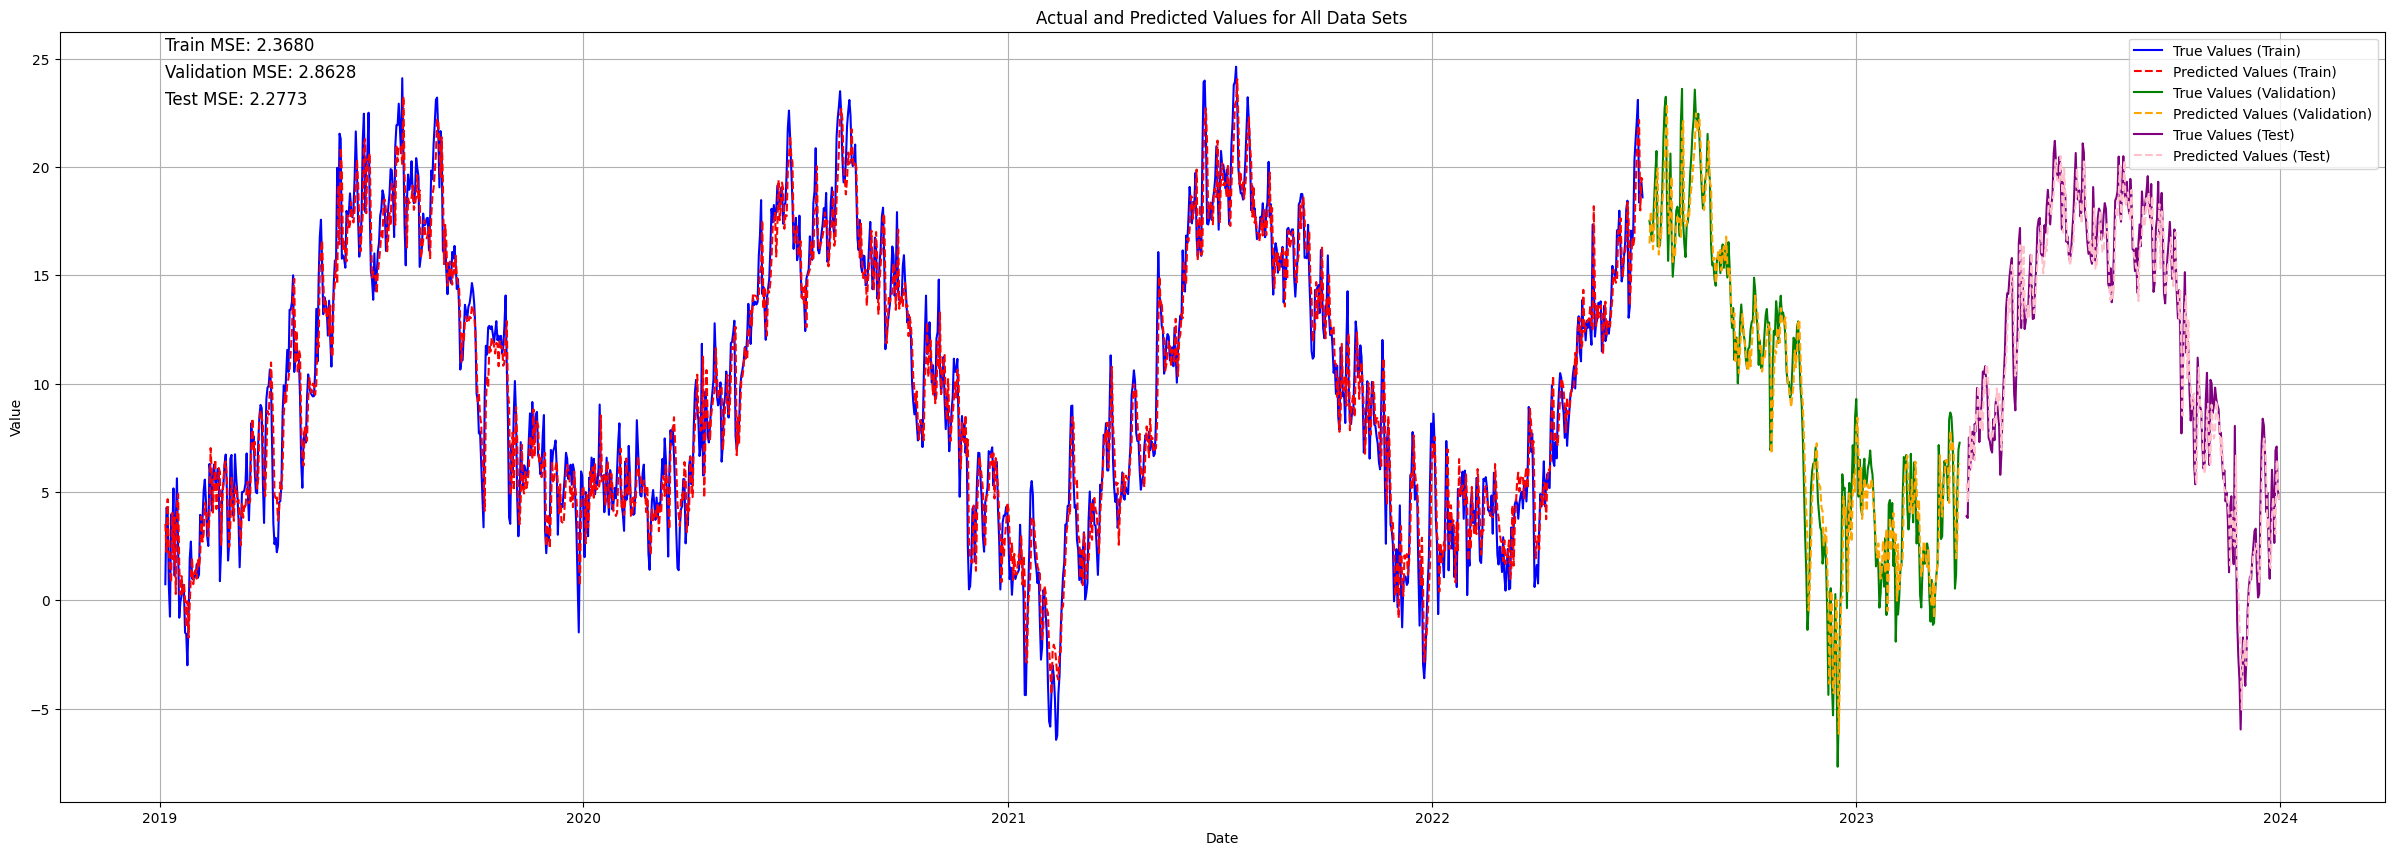

In [ ]:
plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps)

In [ ]:
true_y_test[-10:]

array([[2.57583333],
       [0.99708333],
       [3.85208333],
       [6.02541667],
       [4.815     ],
       [2.65      ],
       [6.9225    ],
       [7.09541667],
       [5.07583333],
       [4.70875   ]])

In [ ]:
true_y_test_pred[-10:]

array([[3.8454812],
       [1.6826379],
       [1.4916751],
       [3.8156326],
       [4.758314 ],
       [4.017783 ],
       [3.0638506],
       [6.4741874],
       [5.5568237],
       [4.675654 ]], dtype=float32)